In [78]:
## MPS Test, fix config, variable replicas with SM=12%，GPU Limit=1.0
## Client vus = 20
import pandas as pd
import json

def getDFfromCSV(file):
    csv = pd.read_csv(file)
    replica, gpu_util, copy_util, sm_active, sm_occu, rps, p95 =[], [], [], [], [], [], []
    for index, row in csv.iterrows():
        limit_json = json.loads(row["limitations"])
        metrics_json = json.loads(row["other_metrics"])

        replica.append(int(limit_json['replicas']))
        gpu_util.append(float(metrics_json['DCGM_FI_DEV_GPU_UTIL']))
        copy_util.append(float(metrics_json['DCGM_FI_DEV_MEM_COPY_UTIL']))
        sm_active.append(float(metrics_json['DCGM_FI_PROF_SM_ACTIVE'])*100)
        sm_occu.append(float(metrics_json['DCGM_FI_PROF_SM_OCCUPANCY'])*100)
        p95.append(float(metrics_json['p95']))
        rps.append(float(row["value"]))
    dfdata = pd.DataFrame({'replica':replica, 'rps':rps, 'p95':p95, 'gpu_util':gpu_util, 'copy_util':copy_util, 'sm_active':sm_active, 'sm_occu':sm_occu})
    # dfdata = dfdata.groupby(['replica']).agg({'rps': 'max'}).reset_index()
    idx = dfdata.groupby(['replica'])['rps'].idxmax()
    dfdata = dfdata.loc[idx]
    # df = df[df.z != -1]
    return dfdata

#records
def setTypeAndName(df, typ, name):
    df['type'] = typ
    df['name'] = name
    
def setDF(name, lst):
    subdir = 'gcloud48/'
    mps12 = getDFfromCSV(subdir+'gcloud48-mps-'+name+'-12.csv')
    mps24 = getDFfromCSV(subdir+'gcloud48-mps-'+name+'-24.csv')
    nm = getDFfromCSV(subdir+'gcloud48-racing-'+name+'.csv')
    setTypeAndName(mps12, 'mps-12%', name)
    setTypeAndName(mps24, 'mps-24%', name)
    setTypeAndName(nm, 'racing', name)
    return lst.extend([mps24, mps12, nm])

lst = []
setDF('rsnt', lst)
setDF('rnnt', lst)
setDF('gnmt', lst)

df_combined = pd.concat(lst, ignore_index=True)


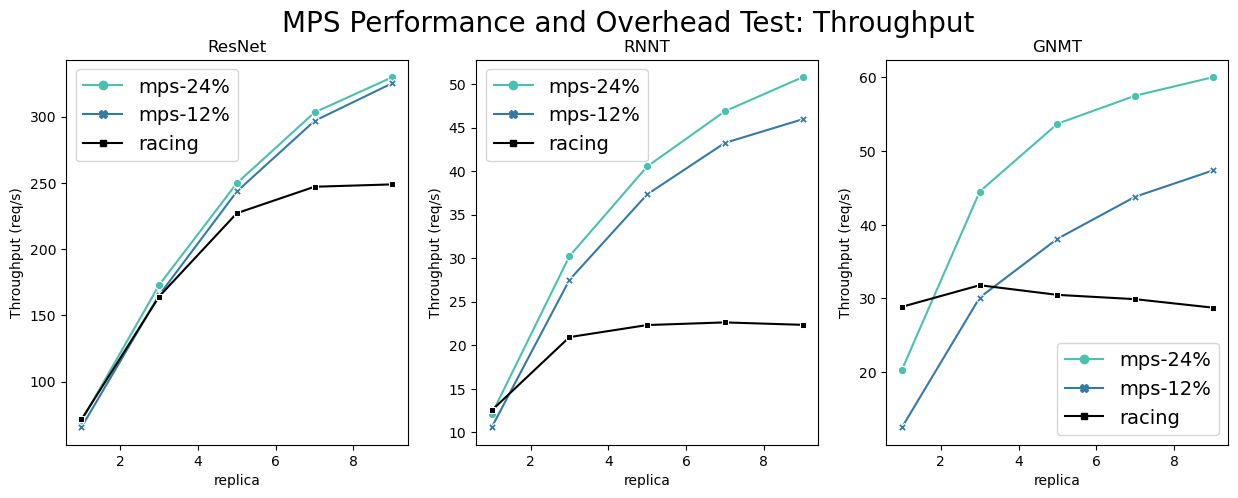

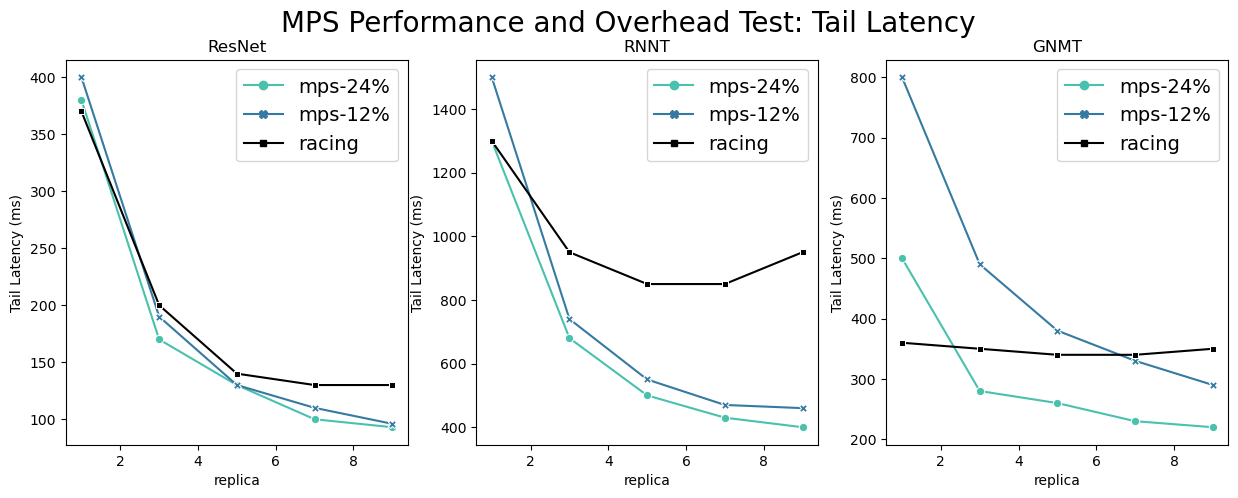

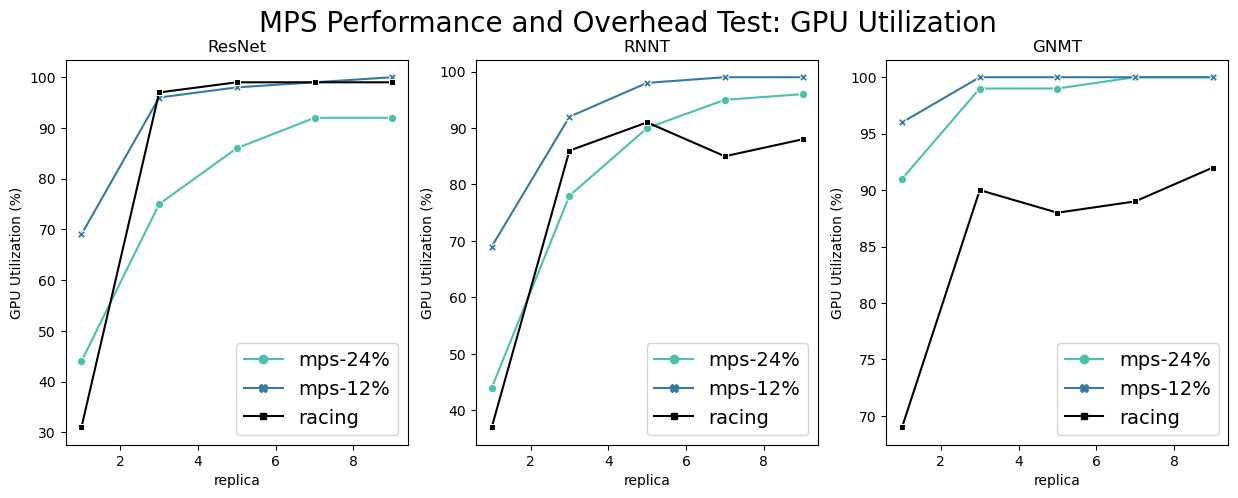

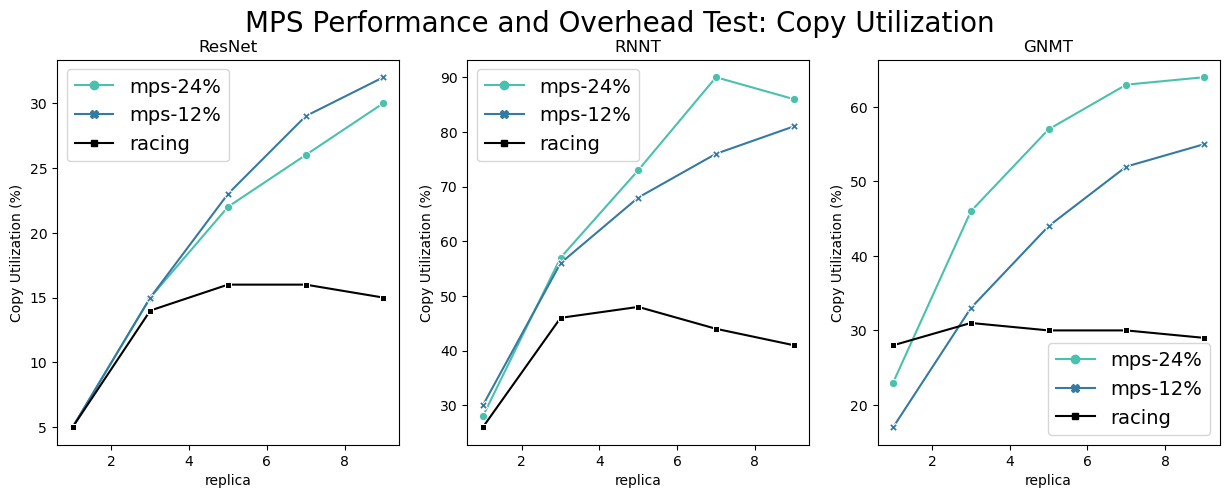

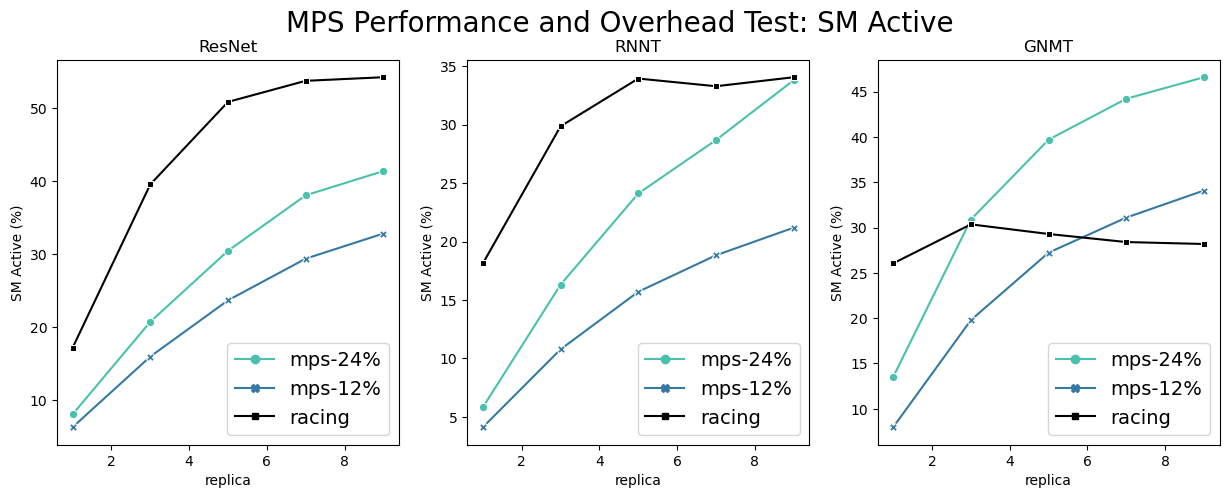

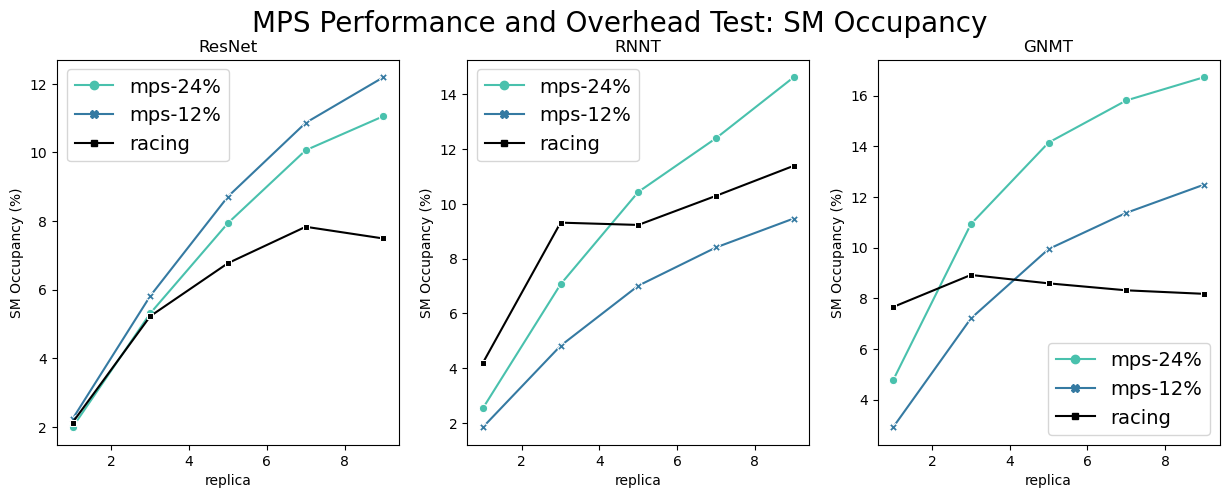

In [79]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

palette = sns.color_palette("mako_r", 3)
palette[-1] = "#000000"
models = ['rsnt', 'rnnt', 'gnmt']
idxMap = {'rsnt':0, 'rnnt':1, 'gnmt':2}
titleMap = {'rsnt':'ResNet', 'gnmt':'GNMT', 'rnnt':'RNNT'}
metricsMap = {'rps':'Throughput', 'p95':'Tail Latency', 'copy_util':'Copy Utilization', 'sm_active':'SM Active', 'sm_occu':'SM Occupancy', 'gpu_util':'GPU Utilization'}
unitMap = {'rps':'req/s', 'p95':'ms', 'copy_util':'%', 'sm_active':'%', 'sm_occu':'%', 'gpu_util':'%'}
for i, col in enumerate(df_combined.columns[:-1]):
    if (col == "replica") | (col == "type") | (col == "name"):
        continue
    fig, axes = plt.subplots(1,3, figsize=(15,5))
    axes = axes.flatten()
    for name in models:
        g = sns.lineplot(x='replica', y=col, hue='type', data=df_combined[df_combined["name"]==name], style="type",
             markers=True, dashes=False,
             palette=palette,
             ax=axes[idxMap[name]]
             )
        g.legend(fontsize=14)
        axes[idxMap[name]].set_title(titleMap[name])
        axes[idxMap[name]].set_ylabel(metricsMap[col] + " (" + unitMap[col] +")")
        
    fig.suptitle("MPS Performance and Overhead Test: " + metricsMap[col], fontsize=20)
    g.figure.savefig(col+".png", format="png")